In [2]:
# Load và chuẩn bị dữ liệu
from pathlib import Path
import pandas as pd
import urllib.request
import seaborn as sns
import matplotlib.pyplot as plt

# URL chứa dataset về cấu hình MySQL (5 knobs/tham số)
url = "https://raw.githubusercontent.com/PKU-DAIR/KnobsTuningEA/refs/heads/master/tuning_benchmark/data/SYSBENCH_5knob.csv"
data_path = Path("btl/dataset/SYSBENCH_5knob.csv")

# Kiểm tra file đã tồn tại chưa để tránh download lại
if not data_path.is_file():
    # Tạo thư mục nếu chưa tồn tại (parents=True: tạo cả thư mục cha)
    Path("btl/dataset").mkdir(parents=True, exist_ok=True)
    # Tải dataset từ GitHub
    urllib.request.urlretrieve(url, data_path)

# Đọc CSV và loại bỏ cột index không cần thiết
configs = pd.read_csv(Path("btl/dataset/SYSBENCH_5knob.csv")).drop("Unnamed: 0", axis=1)

In [3]:
# Xem 5 dòng đầu của dataset
configs.head()

,max_heap_table_size,tmp_table_size,innodb_doublewrite,query_prealloc_size,innodb_thread_concurrency,tps
0,1.677722e+07,16777216.0,1,8192.0,0.0,332.721927
1,5.195222e+08,544013177.0,0,101472750.0,519.0,334.997632
2,6.141391e+08,395733510.0,0,83207073.0,614.0,343.184838
3,7.891182e+08,548395253.0,0,80583681.0,698.0,330.697227
4,1.073742e+09,508516635.0,0,110654782.0,1000.0,339.443657


In [4]:
# Kiểm tra thông tin dataset (kiểu dữ liệu, missing values)
configs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6250 entries, 0 to 6249
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   max_heap_table_size        6250 non-null   float64
 1   tmp_table_size             6250 non-null   float64
 2   innodb_doublewrite         6250 non-null   int64  
 3   query_prealloc_size        6250 non-null   float64
 4   innodb_thread_concurrency  6250 non-null   float64
 5   tps                        6250 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 293.1 KB


In [5]:
# Thống kê mô tả (mean, std, min, max, quartiles)
configs.describe()

,max_heap_table_size,tmp_table_size,innodb_doublewrite,query_prealloc_size,innodb_thread_concurrency,tps
count,6.250000e+03,6.250000e+03,6250.000000,6.250000e+03,6250.000000,6250.000000
mean,7.308685e+08,3.615051e+08,0.121760,8.442150e+07,331.703200,343.333771
std,2.973455e+08,3.520588e+08,0.327035,4.822343e+07,327.525321,22.516352
min,1.638400e+04,1.024000e+03,0.000000,8.192000e+03,0.000000,146.646300
25%,4.883136e+08,2.656921e+07,0.000000,4.140951e+07,45.000000,334.240530
50%,8.003769e+08,2.672265e+08,0.000000,9.771155e+07,212.000000,345.071621
75%,1.009519e+09,6.041552e+08,0.000000,1.316453e+08,495.000000,358.778557
max,1.073742e+09,1.073742e+09,1.000000,1.342177e+08,1000.000000,398.710949


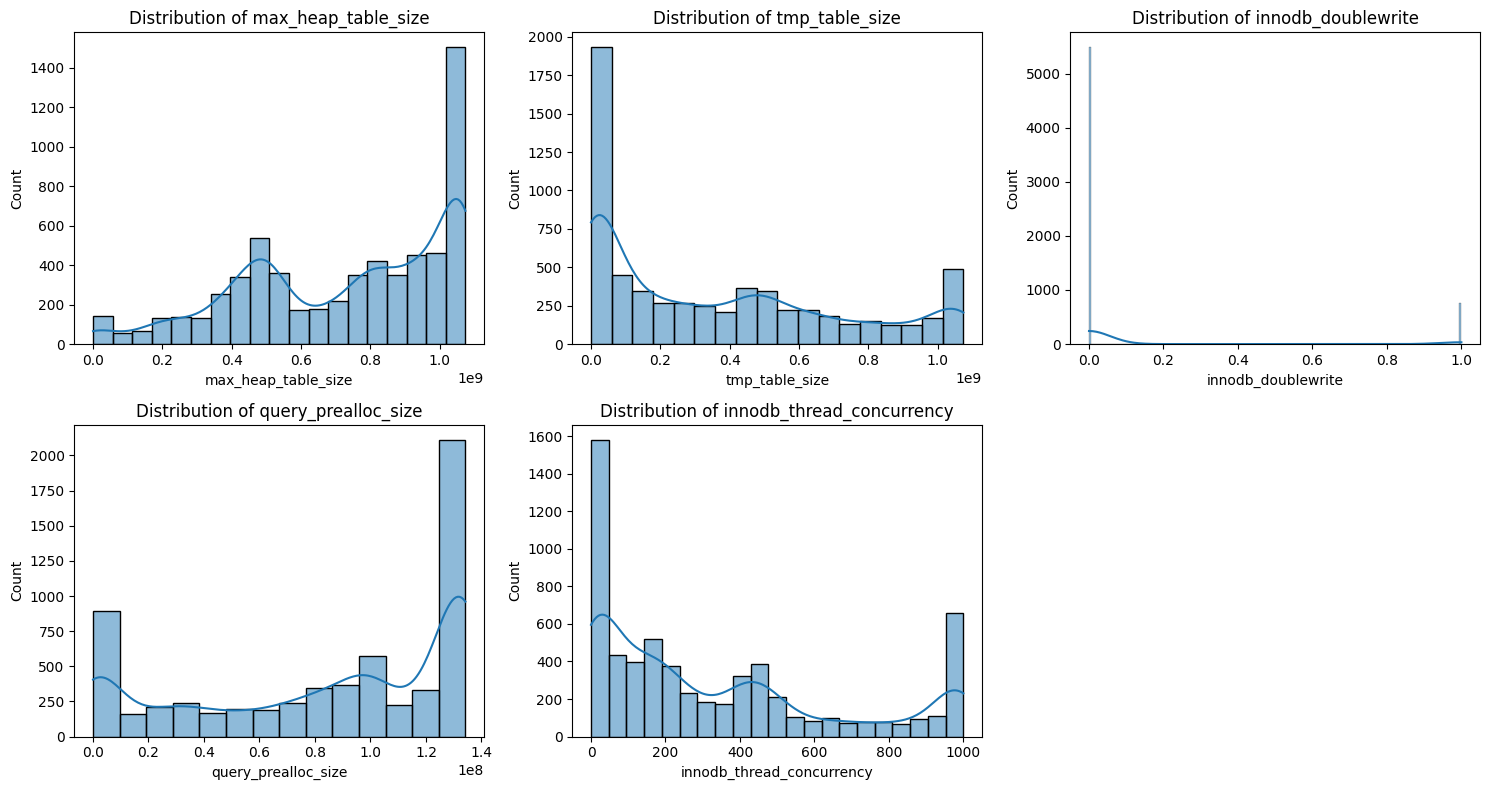

In [6]:
# Vẽ histogram phân bố của các features
data_to_plot = configs.drop("tps", axis=1)  # Loại bỏ target variable

# Tính layout grid: 3 cột, số hàng phụ thuộc số features
n_cols = 3
n_rows = (data_to_plot.shape[1] + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()  # Chuyển 2D array thành 1D

# Vẽ từng feature
for i, col in enumerate(data_to_plot.columns):
    sns.histplot(data_to_plot[col], ax=axes[i], kde=True)  # kde: đường phân bố xác suất
    axes[i].set_title(f"Distribution of {col}", fontsize=12)

# Ẩn subplot thừa
for i in range(len(data_to_plot.columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

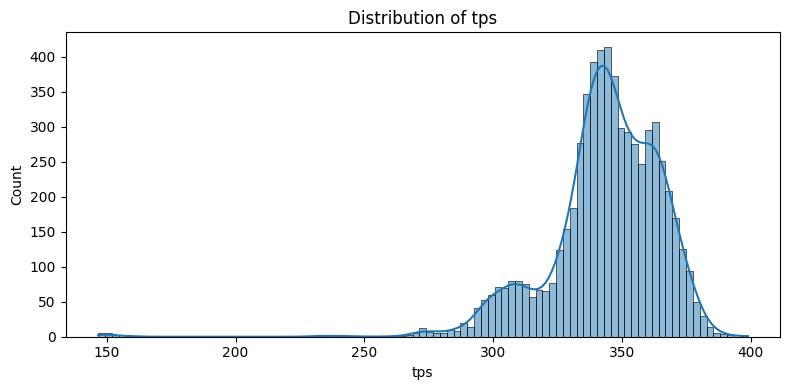

In [7]:
# Vẽ phân bố của target variable (tps)
data_to_plot = configs["tps"].copy()

plt.figure(figsize=(8, 4))
sns.histplot(data_to_plot, kde=True)
plt.title("Distribution of tps", fontsize=12)
plt.tight_layout()
plt.show()

In [8]:
# Chia train/test set
from sklearn.model_selection import train_test_split

# test_size=0.2: 80% train, 20% test
# random_state=42: seed cố định để kết quả reproducible (chạy lại vẫn giống)
train_set, test_set = train_test_split(configs, test_size=0.2, random_state=42)

innodb_doublewrite          -0.501870
innodb_thread_concurrency   -0.341746
tmp_table_size              -0.068978
query_prealloc_size          0.200513
max_heap_table_size          0.200990
Name: tps, dtype: float64


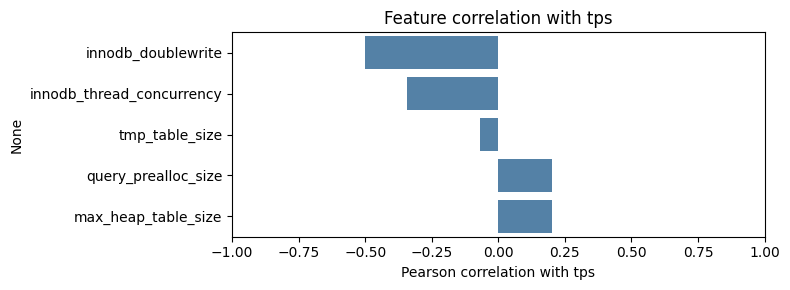

In [9]:
# Phân tích tương quan giữa features và target
# Tính ma trận correlation Pearson
corr = train_set.corr(numeric_only=True)

# Lấy correlation của features với tps, sắp xếp tăng dần
tps_corr = corr["tps"].drop(labels=["tps"]).sort_values()
print(tps_corr)

# Vẽ bar chart
plt.figure(figsize=(8, max(3, 0.35 * len(tps_corr))))
sns.barplot(x=tps_corr.values, y=tps_corr.index, orient="h", color="steelblue")
plt.xlim(-1, 1)  # Correlation range: [-1, 1]
plt.xlabel("Pearson correlation with tps")
plt.title("Feature correlation with tps")
plt.tight_layout()
plt.show()

In [10]:
# Tách features và target
knobs = train_set.drop("tps", axis=1)  # X_train: features
tps = train_set["tps"].copy()  # y_train: target

knobs_test = test_set.drop("tps", axis=1)  # X_test
tps_test = test_set["tps"].copy()  # y_test

In [11]:
# Preprocessing - Chuẩn hóa dữ liệu
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Phân loại features theo loại dữ liệu
categorical_features = ["innodb_doublewrite"]  # Feature categorical (binary: 0/1)
numerical_features = [col for col in knobs.columns if col not in categorical_features]  # Features numerical

# ColumnTransformer: áp dụng các phép biến đổi khác nhau cho từng loại feature
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),  # Chuẩn hóa: z = (x - mean) / std
    ],
    remainder="passthrough",  # Giữ nguyên các cột không được transform
)

# Fit trên train set để học mean, std, categories
preprocessor.fit(knobs)

# Transform train và test với CÙNG parameters
knobs = pd.DataFrame(preprocessor.transform(knobs), columns=knobs.columns)  # type: ignore
knobs_test = pd.DataFrame(preprocessor.transform(knobs_test), columns=knobs.columns)  # type: ignore

In [12]:
# Kiểm tra dữ liệu sau preprocessing
knobs.head()

,max_heap_table_size,tmp_table_size,innodb_doublewrite,query_prealloc_size,innodb_thread_concurrency
0,-0.598006,-0.964375,-1.714073,1.429260,1.0
1,1.149875,1.938595,-1.752437,-1.006655,0.0
2,1.149875,-1.022418,1.024473,-1.006655,0.0
3,1.140834,0.255565,-1.738973,2.042069,0.0
4,-2.448881,-0.658194,1.024473,-1.006655,0.0


In [13]:
from Metrics import mse, mae, r2_score  # Import các hàm đánh giá

model_results = {}  # Dictionary lưu kết quả

In [14]:
from sklearn.linear_model import LinearRegression

model_results = {}  # Dictionary lưu kết quả

lin_reg = LinearRegression()
lin_reg.fit(knobs, tps)

y_pred_lin = lin_reg.predict(knobs_test)

lin_mse = mse(tps_test, y_pred_lin)
lin_mae = mae(tps_test, y_pred_lin)
lin_r2 = r2_score(tps_test, y_pred_lin)

model_results["Scikit Learn Linear Regression"] = {"MSE": lin_mse, "MAE": lin_mae, "R2": lin_r2}
print(f"Scikit Learn Linear Regression MSE: {lin_mse:.2f} TPS")
print(f"Scikit Learn Linear Regression MAE: {lin_mae:.2f} TPS")
print(f"Scikit Learn Linear Regression R2: {lin_r2:.3f}\n")

Scikit Learn Linear Regression MSE: 344.21 TPS
Scikit Learn Linear Regression MAE: 11.41 TPS
Scikit Learn Linear Regression R2: 0.334



In [15]:
from LinearRegression import MyLinearRegression

my_lin_reg = MyLinearRegression()
my_lin_reg.fit(knobs, tps)

y_pred_my_lin = my_lin_reg.predict(knobs_test)

my_lin_mse = mse(tps_test, y_pred_my_lin)
my_lin_mae = mae(tps_test, y_pred_my_lin)
my_lin_r2 = r2_score(tps_test, y_pred_my_lin)

model_results["My Linear Regression"] = {"MSE": my_lin_mse, "MAE": my_lin_mae, "R2": my_lin_r2}
print(f"My Linear Regression MSE: {my_lin_mse:.2f} TPS")
print(f"My Linear Regression MAE: {my_lin_mae:.2f} TPS")
print(f"My Linear Regression R2: {my_lin_r2:.3f}\n")

My Linear Regression MSE: 344.21 TPS
My Linear Regression MAE: 11.41 TPS
My Linear Regression R2: 0.334



In [16]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=100, min_samples_split=2, min_samples_leaf=1, random_state=42)
tree_reg.fit(knobs, tps)

y_pred_tree = tree_reg.predict(knobs_test)

tree_mse = mse(tps_test, y_pred_tree)
tree_mae = mae(tps_test, y_pred_tree)
tree_r2 = r2_score(tps_test, y_pred_tree)

model_results["Scikit Learn Decision Tree"] = {"MSE": tree_mse, "MAE": tree_mae, "R2": tree_r2}
print(f"Scikit Learn Decision Tree MSE: {tree_mse:.2f} TPS")
print(f"Scikit Learn Decision Tree MAE: {tree_mae:.2f} TPS")
print(f"Scikit Learn Decision Tree R2: {tree_r2:.3f}\n")

Scikit Learn Decision Tree MSE: 34.60 TPS
Scikit Learn Decision Tree MAE: 4.07 TPS
Scikit Learn Decision Tree R2: 0.933



In [17]:
from RegressionTree import MyDecisionTreeRegressor

my_tree_reg = MyDecisionTreeRegressor(max_depth=100, min_samples_split=2, min_samples_leaf=1)

my_tree_reg.fit(knobs, tps)

y_pred_my_tree = my_tree_reg.predict(knobs_test)

my_tree_mse = mse(tps_test, y_pred_my_tree)
my_tree_mae = mae(tps_test, y_pred_my_tree)
my_tree_r2 = r2_score(tps_test, y_pred_my_tree)

model_results["My Decision Tree"] = {"MSE": my_tree_mse, "MAE": my_tree_mae, "R2": my_tree_r2}
print(f"My Decision Tree MSE: {my_tree_mse:.2f} TPS")
print(f"My Decision Tree MAE: {my_tree_mae:.2f} TPS")
print(f"My Decision Tree R2: {my_tree_r2:.3f}\n")

My Decision Tree MSE: 34.08 TPS
My Decision Tree MAE: 4.02 TPS
My Decision Tree R2: 0.934



In [18]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(
    n_estimators=1400,  # Số lượng cây dùng để train
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,  # Dùng tất cả CPU cores
    max_depth=100,  # Độ sâu tối đa cho từng cây
    random_state=36,  # Seed cho reproducibility
)

forest_reg.fit(knobs, tps)

y_pred_forest = forest_reg.predict(knobs_test)

forest_mse = mse(tps_test, y_pred_forest)
forest_mae = mae(tps_test, y_pred_forest)
forest_r2 = r2_score(tps_test, y_pred_forest)

model_results["Scikit Learn Random Forest"] = {"MSE": forest_mse, "MAE": forest_mae, "R2": forest_r2}
print(f"Scikit Learn Random Forest MSE: {forest_mse:.2f} TPS")
print(f"Scikit Learn Random Forest MAE: {forest_mae:.2f} TPS")
print(f"Scikit Learn Random Forest R2: {forest_r2:.3f}\n")

Scikit Learn Random Forest MSE: 15.87 TPS
Scikit Learn Random Forest MAE: 2.99 TPS
Scikit Learn Random Forest R2: 0.969



In [19]:
from RandomForest import MyRandomForestRegressor

my_forest_reg = MyRandomForestRegressor(n_estimators=5, min_samples_split=2, min_samples_leaf=1)
my_forest_reg.fit(knobs, tps)

y_pred_my_forest = my_forest_reg.predict(knobs_test)

my_forest_mse = mse(tps_test, y_pred_my_forest)
my_forest_mae = mae(tps_test, y_pred_my_forest)
my_forest_r2 = r2_score(tps_test, y_pred_my_forest)

model_results["My Random Forest"] = {"MSE": my_forest_mse, "MAE": my_forest_mae, "R2": my_forest_r2}
print(f"My Random Forest MSE: {my_forest_mse:.2f} TPS")
print(f"My Random Forest MAE: {my_forest_mae:.2f} TPS")
print(f"My Random Forest R2: {my_forest_r2:.3f}\n")

My Random Forest MSE: 22.74 TPS
My Random Forest MAE: 3.56 TPS
My Random Forest R2: 0.956



In [20]:
print("--- So sánh models ---")
results_df = pd.DataFrame(model_results).T
display(results_df)

--- So sánh models ---


,MSE,MAE,R2
Scikit Learn Linear Regression,344.208172,11.412224,0.334072
My Linear Regression,344.208172,11.412224,0.334072
Scikit Learn Decision Tree,34.604996,4.072294,0.933051
My Decision Tree,34.084572,4.018004,0.934058
Scikit Learn Random Forest,15.870998,2.988562,0.969295
My Random Forest,22.741714,3.557355,0.956002


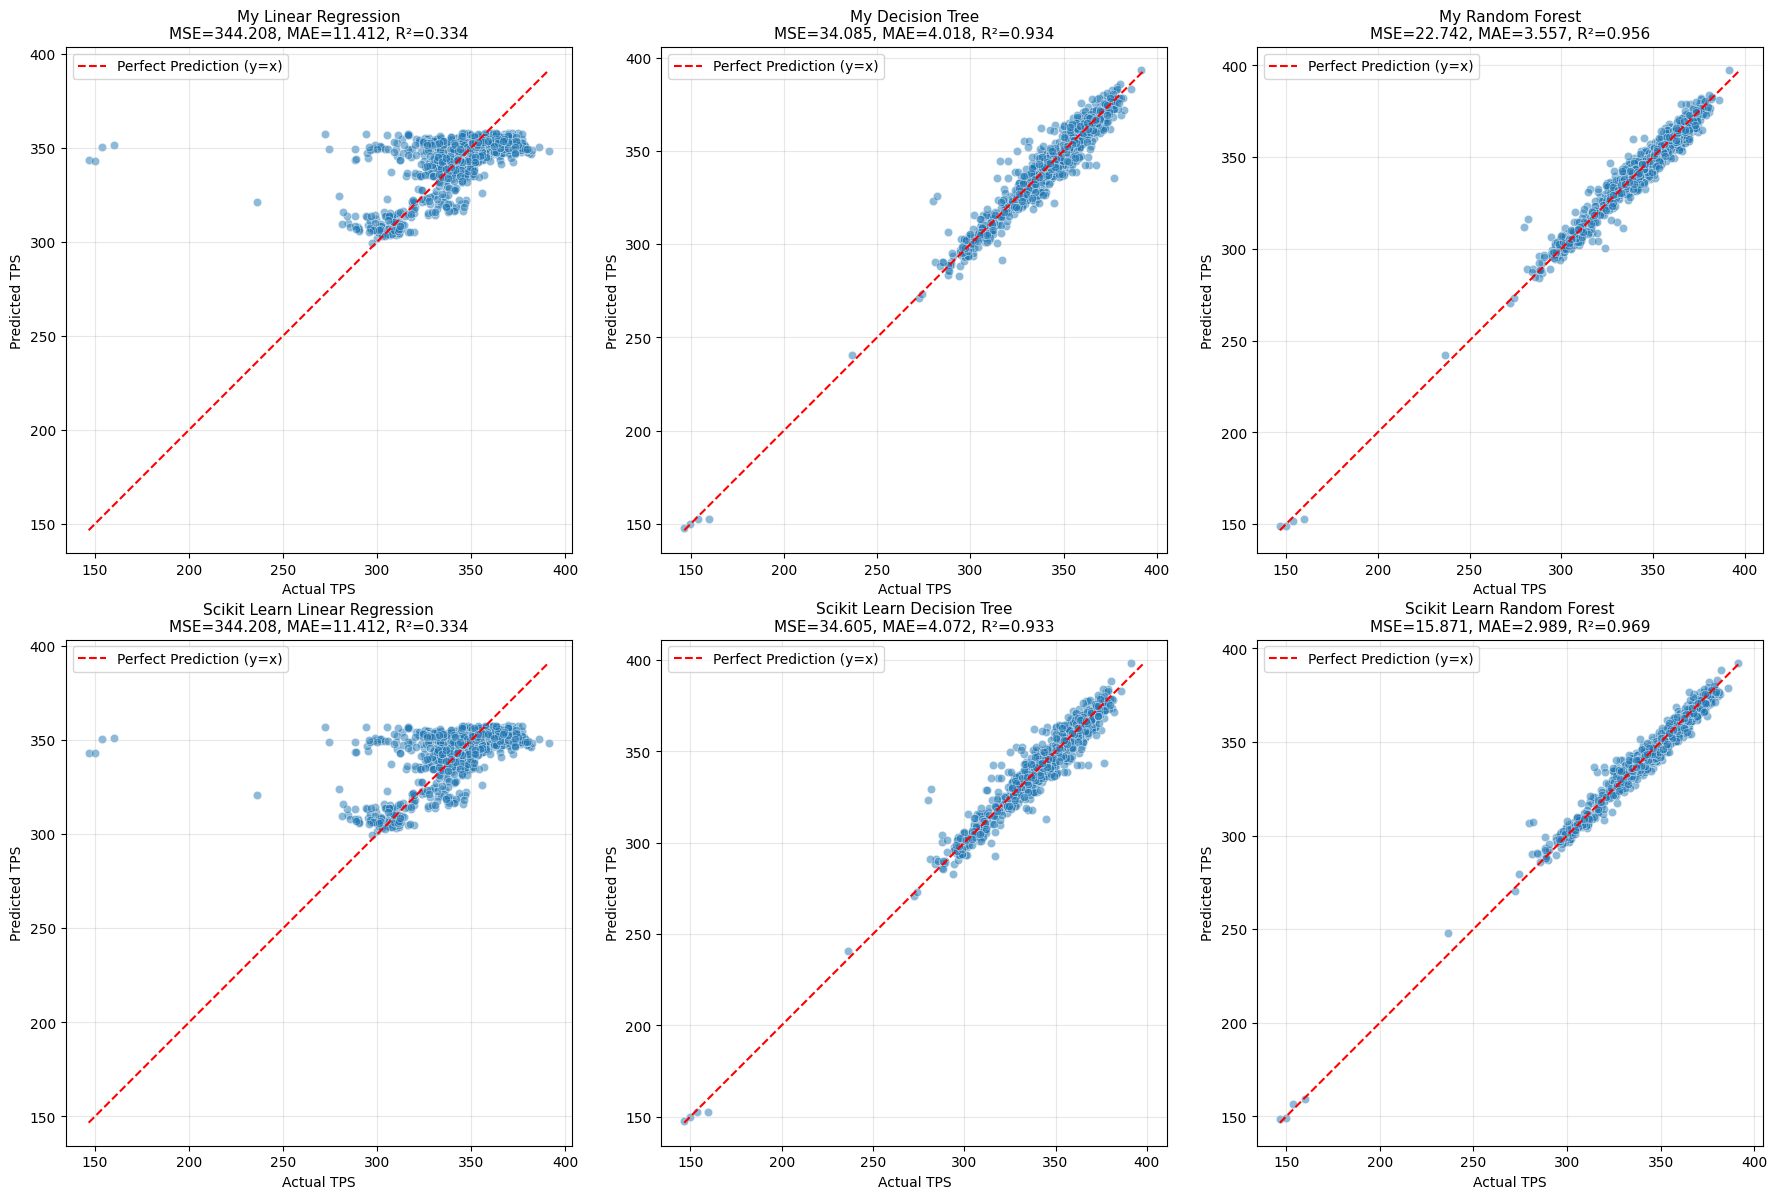

In [21]:
predictions = {
    "My Linear Regression": y_pred_my_lin,
    "My Decision Tree": y_pred_my_tree,
    "My Random Forest": y_pred_my_forest,
    "Scikit Learn Linear Regression": y_pred_lin,
    "Scikit Learn Decision Tree": y_pred_tree,
    "Scikit Learn Random Forest": y_pred_forest,
}

# Tạo các biểu đồ phụ cho tất cả các mô hình
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (model_name, y_pred) in enumerate(predictions.items()):
    ax = axes[idx]

    # Biểu đồ phân tán giữa giá trị thực và giá trị dự đoán
    sns.scatterplot(x=tps_test, y=y_pred, alpha=0.5, ax=ax)

    # Đường y=x: perfect prediction line (điểm càng gần đường này = dự đoán càng chính xác)
    lims = [min(tps_test.min(), y_pred.min()), max(tps_test.max(), y_pred.max())]
    ax.plot(lims, lims, "r--", label="Perfect Prediction (y=x)")

    ax.set_xlabel("Actual TPS", fontsize=10)
    ax.set_ylabel("Predicted TPS", fontsize=10)
    ax.set_title(
        f"{model_name}\nMSE={model_results[model_name]['MSE']:.3f}, MAE={model_results[model_name]['MAE']:.3f}, R²={model_results[model_name]['R2']:.3f}",
        fontsize=11,
    )
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_aspect("equal", adjustable="box")

plt.tight_layout()
plt.show()

In [22]:
# So sánh Train vs Test performance để phát hiện overfitting
import matplotlib.pyplot as plt
import seaborn as sns

# Tính metrics trên TRAIN SET
train_results = {}

# Linear Regression
y_pred_train_lin = lin_reg.predict(knobs)
train_results["Scikit Learn Linear Regression"] = {
    "MSE": mse(tps, y_pred_train_lin),
    "MAE": mae(tps, y_pred_train_lin),
    "R2": r2_score(tps, y_pred_train_lin)
}

# My Linear Regression
y_pred_train_my_lin = my_lin_reg.predict(knobs)
train_results["My Linear Regression"] = {
    "MSE": mse(tps, y_pred_train_my_lin),
    "MAE": mae(tps, y_pred_train_my_lin),
    "R2": r2_score(tps, y_pred_train_my_lin)
}

# Decision Tree
y_pred_train_tree = tree_reg.predict(knobs)
train_results["Scikit Learn Decision Tree"] = {
    "MSE": mse(tps, y_pred_train_tree),
    "MAE": mae(tps, y_pred_train_tree),
    "R2": r2_score(tps, y_pred_train_tree)
}

# My Decision Tree
y_pred_train_my_tree = my_tree_reg.predict(knobs)
train_results["My Decision Tree"] = {
    "MSE": mse(tps, y_pred_train_my_tree),
    "MAE": mae(tps, y_pred_train_my_tree),
    "R2": r2_score(tps, y_pred_train_my_tree)
}

# Random Forest
y_pred_train_forest = forest_reg.predict(knobs)
train_results["Scikit Learn Random Forest"] = {
    "MSE": mse(tps, y_pred_train_forest),
    "MAE": mae(tps, y_pred_train_forest),
    "R2": r2_score(tps, y_pred_train_forest)
}

# My Random Forest
y_pred_train_my_forest = my_forest_reg.predict(knobs)
train_results["My Random Forest"] = {
    "MSE": mse(tps, y_pred_train_my_forest),
    "MAE": mae(tps, y_pred_train_my_forest),
    "R2": r2_score(tps, y_pred_train_my_forest)
}

# Tạo DataFrame để so sánh
train_df = pd.DataFrame(train_results).T
test_df = pd.DataFrame(model_results).T

print("="*80)
print("SO SÁNH TRAIN vs TEST PERFORMANCE")
print("="*80)
print("\n📊 TRAIN SET:")
display(train_df)
print("\n📊 TEST SET:")
display(test_df)

# Tính gap giữa train và test (overfitting indicator)
print("\n⚠️ OVERFITTING GAP (Train - Test):")
gap_df = train_df - test_df
gap_df.columns = [f"Δ{col}" for col in gap_df.columns]
display(gap_df)

SO SÁNH TRAIN vs TEST PERFORMANCE

📊 TRAIN SET:


,MSE,MAE,R2
Scikit Learn Linear Regression,335.466084,11.800570,0.334649
My Linear Regression,335.466084,11.800570,0.334649
Scikit Learn Decision Tree,0.028529,0.011182,0.999943
My Decision Tree,0.028529,0.011182,0.999943
Scikit Learn Random Forest,2.107293,1.120637,0.995820
My Random Forest,5.285655,1.480485,0.989517



📊 TEST SET:


,MSE,MAE,R2
Scikit Learn Linear Regression,344.208172,11.412224,0.334072
My Linear Regression,344.208172,11.412224,0.334072
Scikit Learn Decision Tree,34.604996,4.072294,0.933051
My Decision Tree,34.084572,4.018004,0.934058
Scikit Learn Random Forest,15.870998,2.988562,0.969295
My Random Forest,22.741714,3.557355,0.956002



⚠️ OVERFITTING GAP (Train - Test):


,ΔMSE,ΔMAE,ΔR2
Scikit Learn Linear Regression,-8.742088,0.388346,0.000578
My Linear Regression,-8.742088,0.388346,0.000578
Scikit Learn Decision Tree,-34.576467,-4.061112,0.066893
My Decision Tree,-34.056044,-4.006822,0.065886
Scikit Learn Random Forest,-13.763705,-1.867924,0.026526
My Random Forest,-17.456059,-2.076870,0.033514


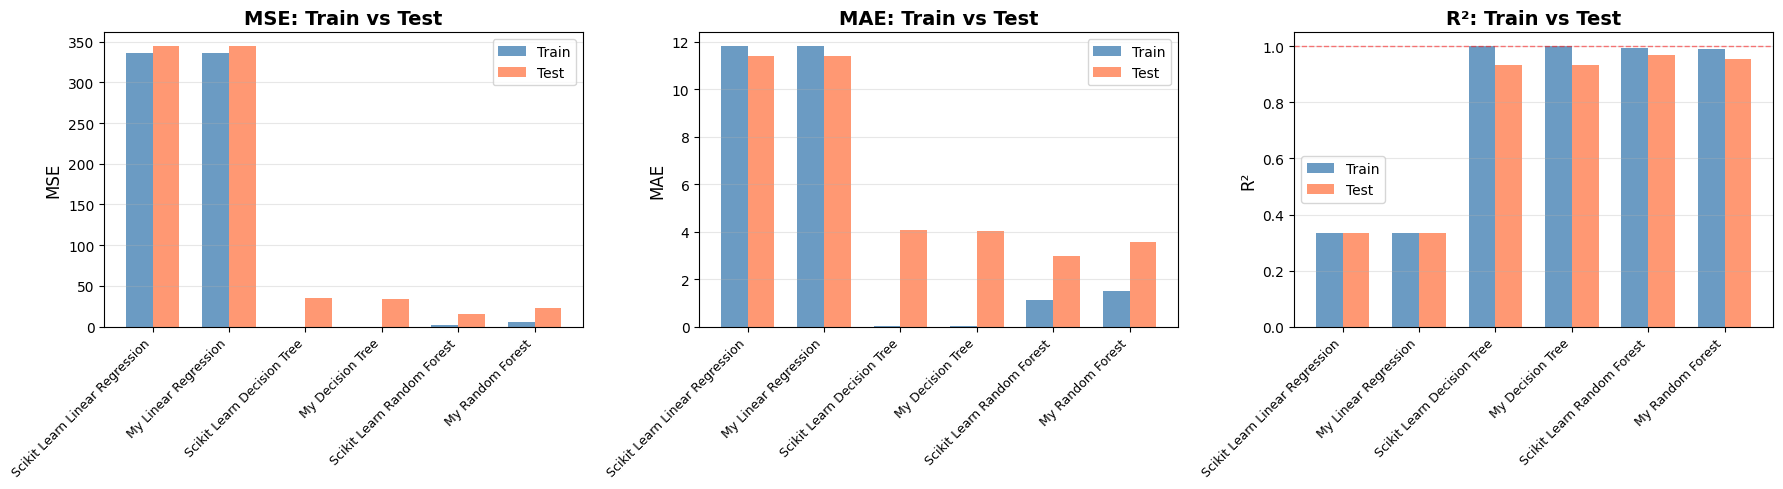

In [23]:
# Vẽ biểu đồ so sánh Train vs Test MSE
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = list(model_results.keys())
train_mse = [train_results[m]["MSE"] for m in models]
test_mse = [model_results[m]["MSE"] for m in models]
train_mae = [train_results[m]["MAE"] for m in models]
test_mae = [model_results[m]["MAE"] for m in models]
train_r2 = [train_results[m]["R2"] for m in models]
test_r2 = [model_results[m]["R2"] for m in models]

x = range(len(models))
width = 0.35

# Plot 1: MSE
axes[0].bar([i - width/2 for i in x], train_mse, width, label='Train', alpha=0.8, color='steelblue')
axes[0].bar([i + width/2 for i in x], test_mse, width, label='Test', alpha=0.8, color='coral')
axes[0].set_ylabel('MSE', fontsize=12)
axes[0].set_title('MSE: Train vs Test', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=45, ha='right', fontsize=9)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: MAE
axes[1].bar([i - width/2 for i in x], train_mae, width, label='Train', alpha=0.8, color='steelblue')
axes[1].bar([i + width/2 for i in x], test_mae, width, label='Test', alpha=0.8, color='coral')
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].set_title('MAE: Train vs Test', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=45, ha='right', fontsize=9)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Plot 3: R²
axes[2].bar([i - width/2 for i in x], train_r2, width, label='Train', alpha=0.8, color='steelblue')
axes[2].bar([i + width/2 for i in x], test_r2, width, label='Test', alpha=0.8, color='coral')
axes[2].set_ylabel('R²', fontsize=12)
axes[2].set_title('R²: Train vs Test', fontsize=14, fontweight='bold')
axes[2].set_xticks(x)
axes[2].set_xticklabels(models, rotation=45, ha='right', fontsize=9)
axes[2].legend()
axes[2].axhline(y=1.0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Perfect R²=1.0')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

🔍 Đang phân tích Learning Curves...



C:\Users\Tung\AppData\Local\Temp\ipykernel_14204\802205732.py:57: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\Hoc\Machine Learning\Project-Machine-Learning\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


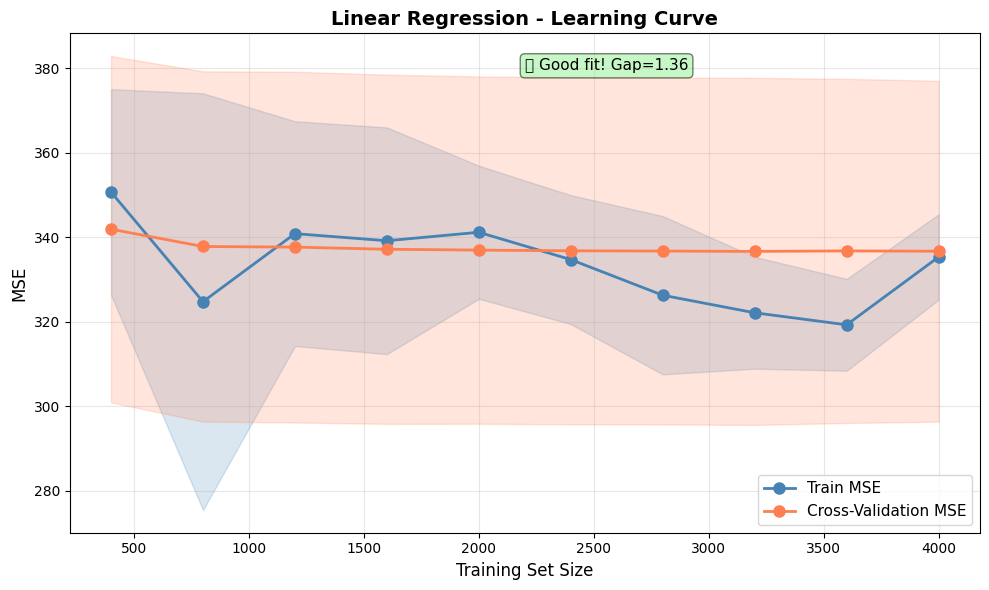

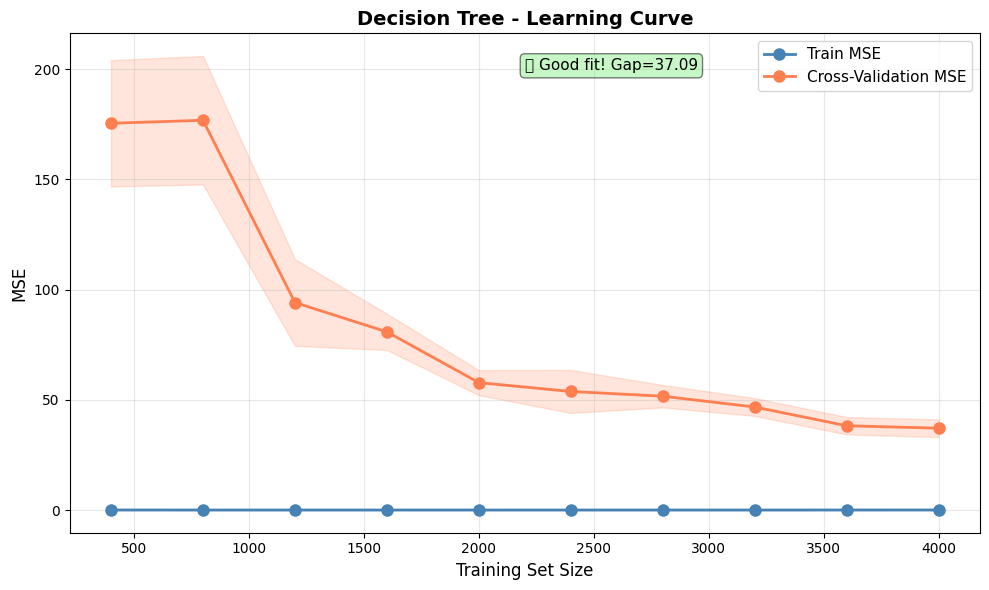

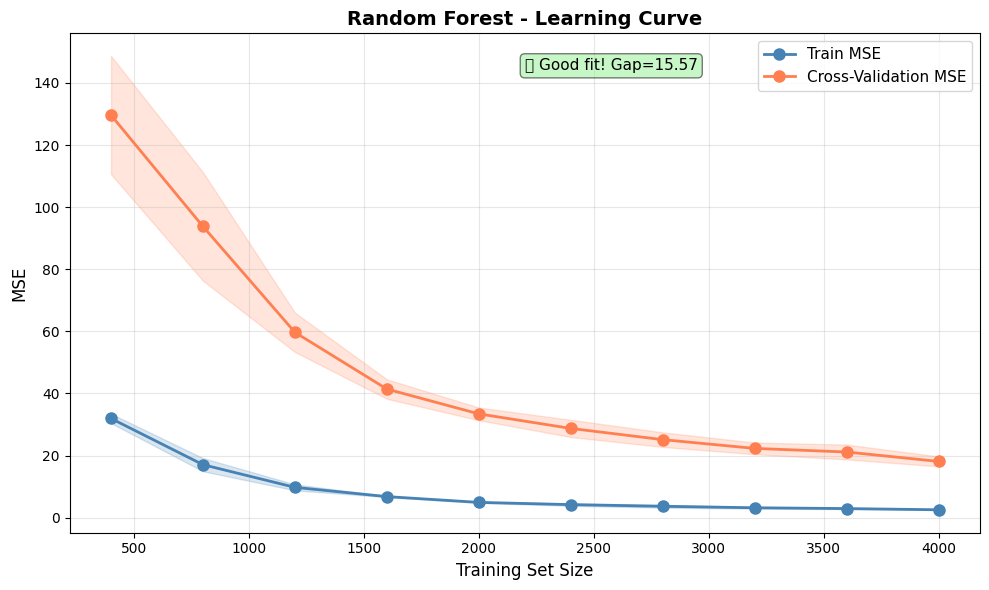

In [25]:
# Learning Curves: Xem performance thay đổi theo training set size
from sklearn.model_selection import learning_curve
import numpy as np 

def plot_learning_curve(estimator, title, X, y):
    """Vẽ learning curve cho một model"""
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5,  # 5-fold cross-validation
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    # Chuyển negative MSE về positive
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel("Training Set Size", fontsize=12)
    plt.ylabel("MSE", fontsize=12)
    
    # Plot với confidence interval
    plt.plot(train_sizes, train_scores_mean, 'o-', color="steelblue", 
             label="Train MSE", linewidth=2, markersize=8)
    plt.fill_between(train_sizes, 
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.2, color="steelblue")
    
    plt.plot(train_sizes, test_scores_mean, 'o-', color="coral", 
             label="Cross-Validation MSE", linewidth=2, markersize=8)
    plt.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, 
                     alpha=0.2, color="coral")
    
    plt.legend(loc="best", fontsize=11)
    plt.grid(alpha=0.3)
    
    # Phân tích overfitting
    final_gap = abs(train_scores_mean[-1] - test_scores_mean[-1])
    if final_gap > 50:  # Threshold tùy chỉnh
        plt.text(0.5, 0.95, f'⚠️ Overfitting! Gap={final_gap:.2f}', 
                transform=plt.gca().transAxes, 
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5),
                fontsize=11, verticalalignment='top')
    else:
        plt.text(0.5, 0.95, f'✅ Good fit! Gap={final_gap:.2f}', 
                transform=plt.gca().transAxes, 
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5),
                fontsize=11, verticalalignment='top')
    
    plt.tight_layout()
    plt.show()

# Vẽ learning curves cho các models
print("🔍 Đang phân tích Learning Curves...\n")

plot_learning_curve(lin_reg, "Linear Regression - Learning Curve", knobs, tps)
plot_learning_curve(tree_reg, "Decision Tree - Learning Curve", knobs, tps)
plot_learning_curve(forest_reg, "Random Forest - Learning Curve", knobs, tps)

In [ ]:
# Nhập dữ liệu và dự đoán TPS với tất cả các mô hình

def predict_tps_from_input():
    """Nhập cấu hình Amazon RDS for MySQL từ terminal và dự đoán TPS với tất cả mô hình"""
    
    print("\n" + "="*60)
    print("CHƯƠNG TRÌNH DỰ ĐOÁN TPS CHO CẤU HÌNH AMAZON RDS FOR MYSQL")
    print("="*60 + "\n")
    
    # Nhập các tham số Amazon RDS for MySQL
    print("Nhập các tham số cấu hình Amazon RDS for MySQL:")
    print("-"*60)
    
    try:
        # Lấy tên features từ train_set gốc 
        feature_names = train_set.drop("tps", axis=1).columns.tolist()
        input_data = {}
        
        for feature in feature_names:
            while True:
                try:
                    if feature == "innodb_doublewrite":
                        value = input(f"{feature} (0 hoặc 1): ").strip()
                        value = int(value)
                        if value not in [0, 1]:
                            raise ValueError
                    else:
                        value = input(f"{feature}: ").strip()
                        value = float(value)
                    
                    input_data[feature] = value
                    break
                except ValueError:
                    print(f"❌ Giá trị không hợp lệ cho {feature}. Vui lòng nhập lại!")
        
        # Hiển thị thông tin đã nhập
        print("\n" + "="*60)
        print("THÔNG TIN ĐÃ NHẬP")
        print("="*60)
        for feature, value in input_data.items():
            print(f"  • {feature}: {value}")
        
        # Tạo DataFrame với thứ tự cột giống train_set gốc
        input_df = pd.DataFrame([input_data])[feature_names]
        
        # Chuẩn hóa dữ liệu giống như training data
        input_normalized = preprocessor.transform(input_df)
        
        # Chuyển về DataFrame - SỬ DỤNG CÙNG TÊN CỘT VỚI knobs đã transform
        input_normalized = pd.DataFrame(input_normalized, columns=knobs.columns)
        
        # Dự đoán với tất cả các mô hình
        print("\n" + "="*60)
        print("KẾT QUẢ DỰ ĐOÁN TPS TỪ TẤT CẢ CÁC MÔ HÌNH")
        print("="*60 + "\n")
        
        # In từng model một để đảm bảo không bị mất
        pred1 = my_lin_reg.predict(input_normalized)[0]
        print(f"1. My Linear Regression..................... {pred1:.2f} TPS")
        
        pred2 = my_tree_reg.predict(input_normalized)[0]
        print(f"2. My Decision Tree......................... {pred2:.2f} TPS")
        
        pred3 = my_forest_reg.predict(input_normalized)[0]
        print(f"3. My Random Forest......................... {pred3:.2f} TPS")
        
        pred4 = lin_reg.predict(input_normalized)[0]
        print(f"4. Scikit Learn Linear Regression........... {pred4:.2f} TPS")
        
        pred5 = tree_reg.predict(input_normalized)[0]
        print(f"5. Scikit Learn Decision Tree............... {pred5:.2f} TPS")
        
        pred6 = forest_reg.predict(input_normalized)[0]
        print(f"6. Scikit Learn Random Forest............... {pred6:.2f} TPS")
        
        print("\n" + "="*60 + "\n")
        
    except KeyboardInterrupt:
        print("\n\n❌ Đã hủy chương trình!")
    except Exception as e:
        print(f"\n❌ Lỗi: {e}")

predict_tps_from_input()


CHƯƠNG TRÌNH DỰ ĐOÁN TPS CHO CẤU HÌNH AMAZON RDS FOR MYSQL

Nhập các tham số cấu hình Amazon RDS for MySQL:
------------------------------------------------------------

THÔNG TIN ĐÃ NHẬP
  • max_heap_table_size: 900.0
  • tmp_table_size: 900.0
  • innodb_doublewrite: 0
  • query_prealloc_size: 5000.0
  • innodb_thread_concurrency: 5000.0

KẾT QUẢ DỰ ĐOÁN TPS TỪ TẤT CẢ CÁC MÔ HÌNH

1. My Linear Regression..................... 265.00 TPS
2. My Decision Tree......................... 335.55 TPS
3. My Random Forest......................... 333.52 TPS
4. Scikit Learn Linear Regression........... 265.00 TPS
5. Scikit Learn Decision Tree............... 335.55 TPS
6. Scikit Learn Random Forest............... 335.20 TPS


